In [2]:
import numpy as np
import pandas as pd
import os
import json
from matplotlib import pyplot as plt

import cv2

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

In [38]:
class Config:
    SEED = 42
    RATIO = 0.25

    DIM = (256, 256)

    VAL_SPLIT = 0.25
    BATCH_SIZE = 2
    EPOCHS = 10

    TARGET_COLS = []

    AUTOTUNE = tf.data.AUTOTUNE


CFG = Config()

image_path = "raw_data/images/"
annotation_path = "raw_data/annotations/"

test_path = "raw_data/images/*.jpg"
test_img = "raw_data/images/00-BnNquK24qWw8IAFyXJQ.jpg"
test_anno = "raw_data/annotations/00-BnNquK24qWw8IAFyXJQ.json"

In [39]:
def load_img(path):
    img = cv2.imread(path)

    width = int(img.shape[1] * CFG.RATIO)
    height = int(img.shape[0] * CFG.RATIO)
    dim = (width, height)

    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    img = tf.image.rgb_to_grayscale(img)
    return tf.cast(img, tf.float32)


def load_img_256(path):
    img = cv2.imread(path)

    dim = CFG.DIM

    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    img = tf.image.rgb_to_grayscale(img)
    return tf.cast(img, tf.float32)

In [40]:
def load_annotation(path):
    labels = []
    bboxs = []
    feature_keys = ["xmin", "ymin", "xmax", "ymax"]

    with open(path) as f:
        file = json.load(f)
    datas = file.get("objects")

    if datas:
        for data in datas:
            if data["label"] != "other-sign":
                labels.append(data["label"])
                bboxs.append(data["bbox"])
            else:
                # print('Wrong Label')
                pass

    labels = tf.strings.as_string(labels)
    bboxs = [[int(data[key]) for key in feature_keys] for data in bboxs]
    bboxs = tf.constant(bboxs, dtype=tf.int64)

    return labels, bboxs

In [46]:
def load_data(path):
    path = tf.convert_to_tensor(path)
    path = bytes.decode(path.numpy())
    filename = path.split("/")[-1].split(".")[0]

    image_path = os.path.join("raw_data", "images", f"{filename}.jpg")
    annotation_path = os.path.join("raw_data", "annotations", f"{filename}.json")

    images = load_img_256(image_path)
    labels, bboxs = load_annotation(annotation_path)

    return images, labels, bboxs

In [47]:
def mappable_func(path):
    result = tf.py_function(load_data, [path], (tf.float32, tf.string, tf.int64))
    return result

In [48]:
def build_dataset(path):
    nb_data = len(list(tf.data.Dataset.list_files(path)))  # Get the size of the dataset

    data = (
        tf.data.Dataset.list_files(path)
        .shuffle(nb_data, reshuffle_each_iteration=False)
        .map(mappable_func)
        .batch(CFG.BATCH_SIZE)
        .prefetch(CFG.AUTOTUNE)
    )

    return data

In [49]:
def split_data(data):
    nb_data = int(len(data) * CFG.VAL_SPLIT)
    train = data.take(nb_data)
    test = data.skip(nb_data)

    return train, test

In [50]:
img, label, bbox = load_data(test_img)
# label, bbox = annotation

In [52]:
img

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[206.],
        [204.],
        [204.],
        ...,
        [171.],
        [168.],
        [164.]],

       [[205.],
        [204.],
        [204.],
        ...,
        [172.],
        [167.],
        [163.]],

       [[204.],
        [203.],
        [203.],
        ...,
        [171.],
        [165.],
        [164.]],

       ...,

       [[ 76.],
        [ 75.],
        [ 75.],
        ...,
        [ 75.],
        [ 75.],
        [ 81.]],

       [[ 73.],
        [ 72.],
        [ 74.],
        ...,
        [ 84.],
        [ 84.],
        [ 80.]],

       [[ 71.],
        [ 72.],
        [ 73.],
        ...,
        [ 80.],
        [ 90.],
        [ 82.]]], dtype=float32)>

In [53]:
# my_bbox = [int(x) for x in my_bbox]
my_bbox = bbox.numpy()
my_bbox[0, 1]

1161

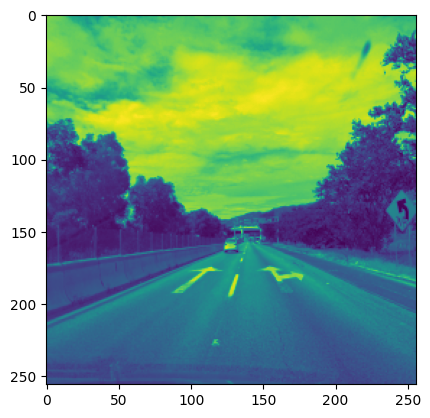

In [54]:
plt.imshow(img)

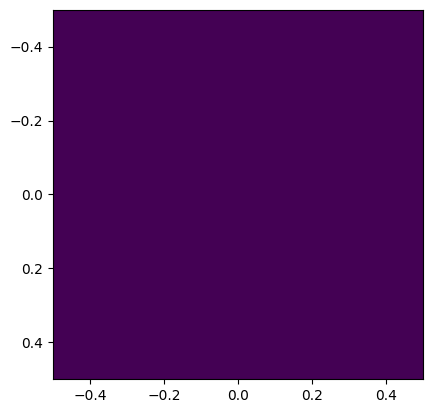

In [56]:
plt.imshow(
    img[
        int(my_bbox[0, 1] / 256) : int(my_bbox[0, 3] / 256),
        int(my_bbox[0, 0] / 256) : int(my_bbox[0, 2] / 256),
    ]
)

In [76]:
data = build_dataset(path="raw_data/images/*.jpg")

In [77]:
train, test = split_data(data)

In [78]:
sample = data.as_numpy_iterator()

In [79]:
val = sample.next()

In [ ]:
def initiate_model():
    # Initialize the model
    model = Sequential()

    # Add input layer
    model.add(layers.Input(shape=(X_train.shape[1],)))

    # Add hidden layers
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))

    # Add output layer
    model.add(layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])